# BE/Bi 103, Fall 2016: Homework 5
## Due 1pm, Sunday, October 30

(c) 2016 Justin Bois. This work is licensed under a [Creative Commons Attribution License CC-BY 4.0](https://creativecommons.org/licenses/by/4.0/). All code contained therein is licensed under an [MIT license](https://opensource.org/licenses/MIT).

*This homework was generated from an Jupyter notebook.  You can download the notebook [here](hw5_solutions.ipynb).*

In [122]:
import collections
import glob
import os

import numpy as np
import numba
import pandas as pd
import sklearn.neighbors
import sklearn.preprocessing
import scipy.stats as st
import skimage.filters
import matplotlib.path
import matplotlib._cntr

import matplotlib.pyplot as plt
import seaborn as sns
rc={'lines.linewidth': 2, 'axes.labelsize': 14, 'axes.titlesize': 14}
sns.set(rc=rc)

import emcee
import corner

import bebi103

# Make Matplotlib plots appear inline
%matplotlib inline

### Problem 5.3: solutions

We will start with the extra credit first, showing how we do automatic gating. Before beginning the gating procedure, we will load in a test data set and extract the forward scattering area, side scattering area, and fluorescence from the DataFrame. We will only consider 

In [12]:
# Get scattering data
df = pd.read_csv('../data/flow_data/20160807_0_RBS1027_10.0.csv')
inds = (df['FSC-A'] > 0) & (df['SSC-A'] > 0) & (df['FITC-A'] > 0)
fsc, ssc, yfp = df.loc[inds,['FSC-A', 'SSC-A', 'FITC-A']].values.transpose()

#### Gating with the histogram method

For the first method, we do the following.
1. Compute a 2D histogram of the forward/side scattering data.
2. Optionally smooth the 2D histogram with a Gaussian filter.
3. Draw a contour corresponding to a given percentile. E.g., if we want only the data points that with the most often encountered forward/side scattering pairs, we would choose a high percentile, like 90.
4. Retain all points within this contour.

To get a feel for how it works, let's first plot our data with some contours. We will plot the contours that contain the top 10, 20, 50, and 80 percent of the data.

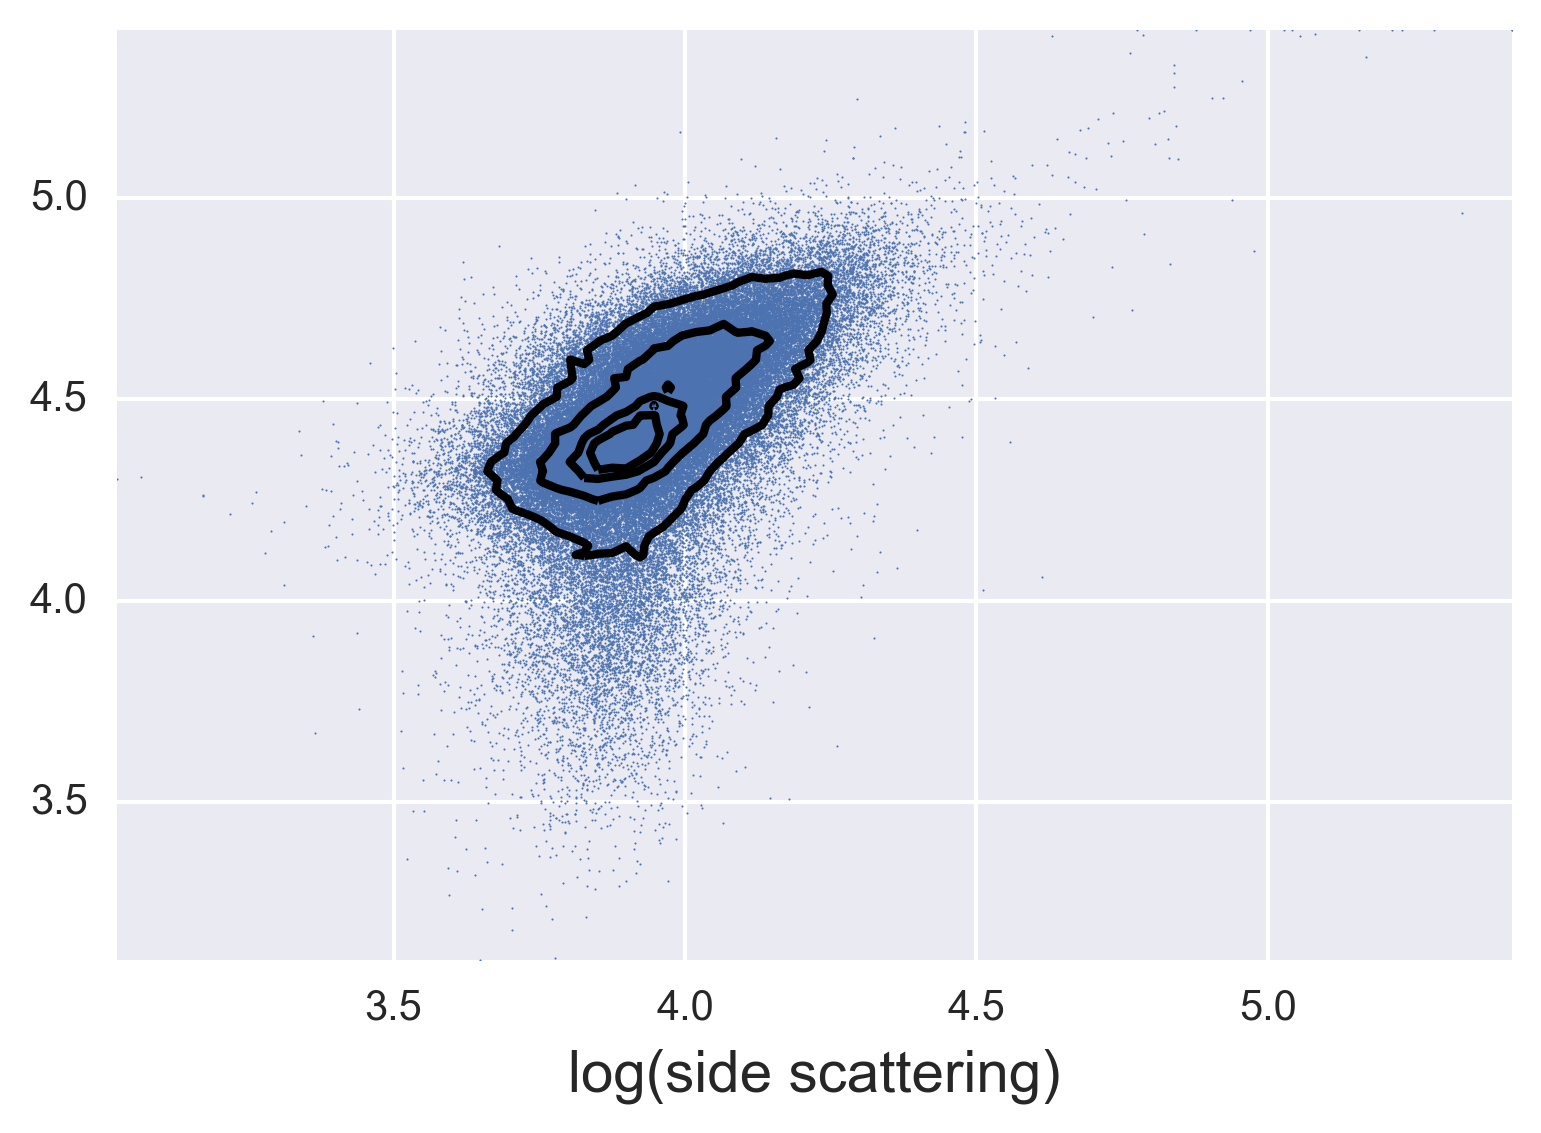

In [3]:
# Generate x, y, z data for histogram
z, x, y = bebi103.norm_cumsum_2d(np.log10(fsc), np.log10(ssc), bins=100)

# Plot the data
plt.plot(np.log10(fsc), np.log10(ssc), '.', markersize=1, rasterized=True)

# Plot contours for 50th, 80th, and 90th percentiles
plt.contour(x, y, z, levels=[0.1, 0.2, 0.5, 0.8], colors='black', zorder=3)

# Label axes
plt.xlabel('log(forward scattering)')
plt.xlabel('log(side scattering)');

We might want to choose all of the points in the innermost contour, which would correspond to the 90th percentile and above.

To code this up, we first need to pay attention to the fact that sometimes the contours are disconnected. For example, in the above plot, we can see that for some levels, there are a couple small contours disconnected from the large one. We want to only consider the largest contour, so we'll write a function to compute the area of a contour.

In [4]:
def shoelace_area(x, y):
    """
    Compute the area of a regular polygon using the shoelace formula.
    
    Parameters
    ----------
    x : ndarray
        x-coordinates of vertices of regular polygon
    y : ndarray
        y-coordinates of verticies of regular polygon
        
    Returns
    -------
    output : float
        Area of regular polygon.
    
    Notes
    -----
    .. See https://en.wikipedia.org/wiki/Shoelace_formula.

    .. If the polygon is irregular (has crossing lines), the result
       will be bogus, and no warning will be given.
    """
    return np.abs(np.dot(x, np.roll(y, 1)) - np.dot(np.roll(x, 1), y)) / 2    

Now that we have that, we can code up our gating. The function will return an array of Booleans that say whether or not we should include a given data point. In this function, we use the `matplotlib._cntr` submodule, which is deep the guts of Matplotlib, which is what generates the contours under the hood.

In [5]:
def gate_histogram(fsc, ssc, bins=100, uselog=True, percentile=80, 
                   smooth_sigma=None):
    """
    Gate flow data using the 2D histogram method.
    
    Parameters
    ----------
    fsc : ndarray
        Forward scattering data
    ssc : ndarray
        Side scattering data
    bins : int, default 100
        Number of bins along each access to use in histogram
    uselog : bool, default True
        If True, use the logarithm of scattering data to generate
        histogram.
    percentile : float, default 80
        Include data points within a contour that encompasses the
        highest percentile of the data. E.g., if percentile = 90,
        data points within the contour containing the top 10% densest
        regions are used.
    smooth_sigma : float, default None
        If not None, then Gaussian smoothing is applied to the 
        2D histogram prior to drawing the contour. The smoothing kernel
        has sigma equal to smooth_sigma * extent of data. Recommended value
        is smooth_sigme = 0.01.
        
    Returns
    -------
    inds : ndarray of bools
        inds[i] is True if cell i is to be included and False otherwise.
        
    Notes
    -----
    .. It is not always possible to draw a contour. This most often
       happens when uselog=False and Gaussian smoothing is applied.
    """
    
    # Generate a 2D normalized histogram of data
    if uselog:
        z, x, y = bebi103.norm_cumsum_2d(np.log(fsc), np.log(ssc), bins=bins)
    else:
        z, x, y = bebi103.norm_cumsum_2d(fsc, ssc, bins=bins)

    # Smooth the histogram
    if smooth_sigma is not None:
        sigma = smooth_sigma * bins
        z = skimage.filters.gaussian(z, sigma)
        
    # Get the contour
    xx, yy = np.meshgrid(x, y)
    contour = matplotlib._cntr.Cntr(xx, yy, z)
    c = contour.trace((100-percentile) / 100)
    
    # Check to make sure we could generate a contour
    if len(c) == 0:
        raise RuntimeError('Unable to draw contour. Check input settings.')
    
    # Extract only polygons (last half of list is matplotlib details)
    c = c[:len(c)//2]
 
    # Use the contour that has the most area
    ind = np.argmax(np.array([shoelace_area(*pgon.T) for pgon in c]))

    # Make a matplotlib Path object so we can see if points are inside
    polygon = matplotlib.path.Path(c[ind][:-1])
    
    # Get points within polygon
    if uselog:
        return polygon.contains_points(np.vstack((np.log(fsc), np.log(ssc))).T)
    else:
        return polygon.contains_points(np.vstack((fsc, ssc)).T)

Now let's try gating this sample and plot the results.

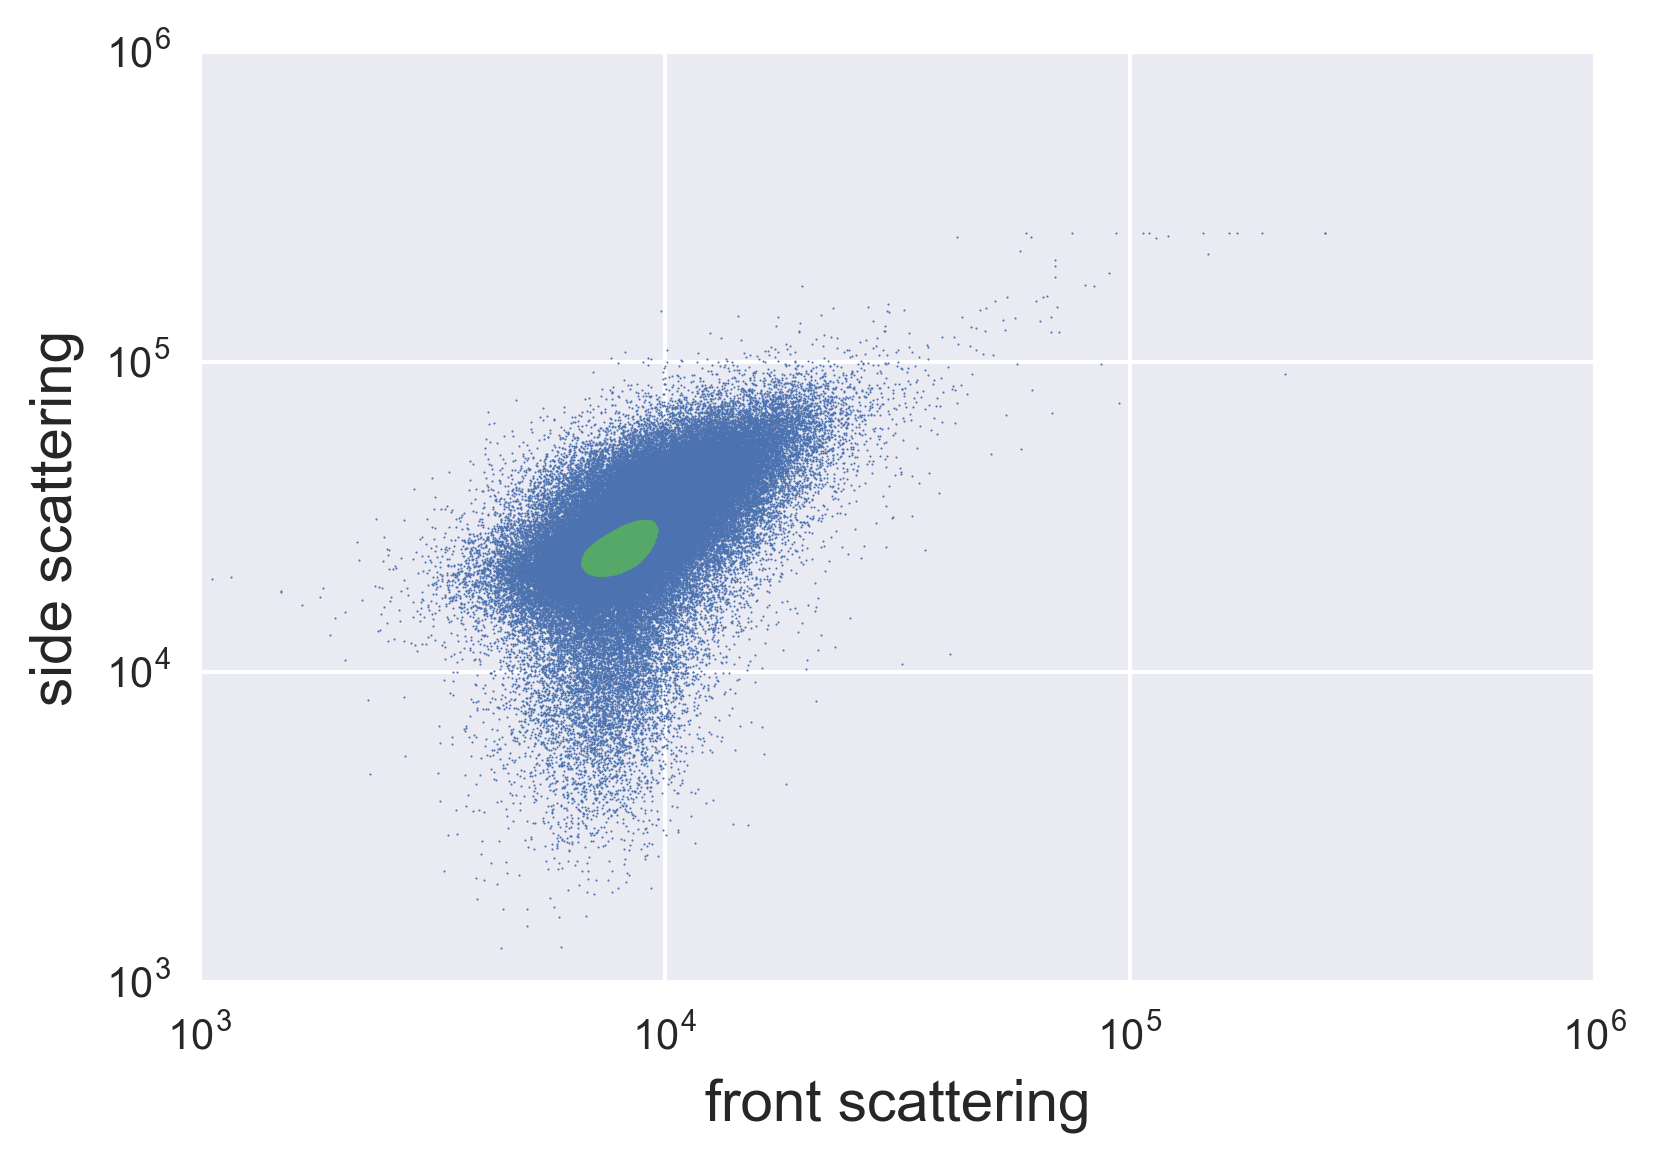

In [6]:
# Perform the gating
inds = gate_histogram(fsc, ssc, percentile=80, smooth_sigma=0.01)

# Plot the excluded and included data
plt.loglog(fsc[~inds], ssc[~inds], '.', markersize=1, rasterized=True)
plt.loglog(fsc[inds], ssc[inds], '.', markersize=1, rasterized=True)
plt.xlabel('forward scattering')
plt.ylabel('side scattering');

So, we got a nice subset of the data. Let's plot an ECDF of the fluorescence intensity values.

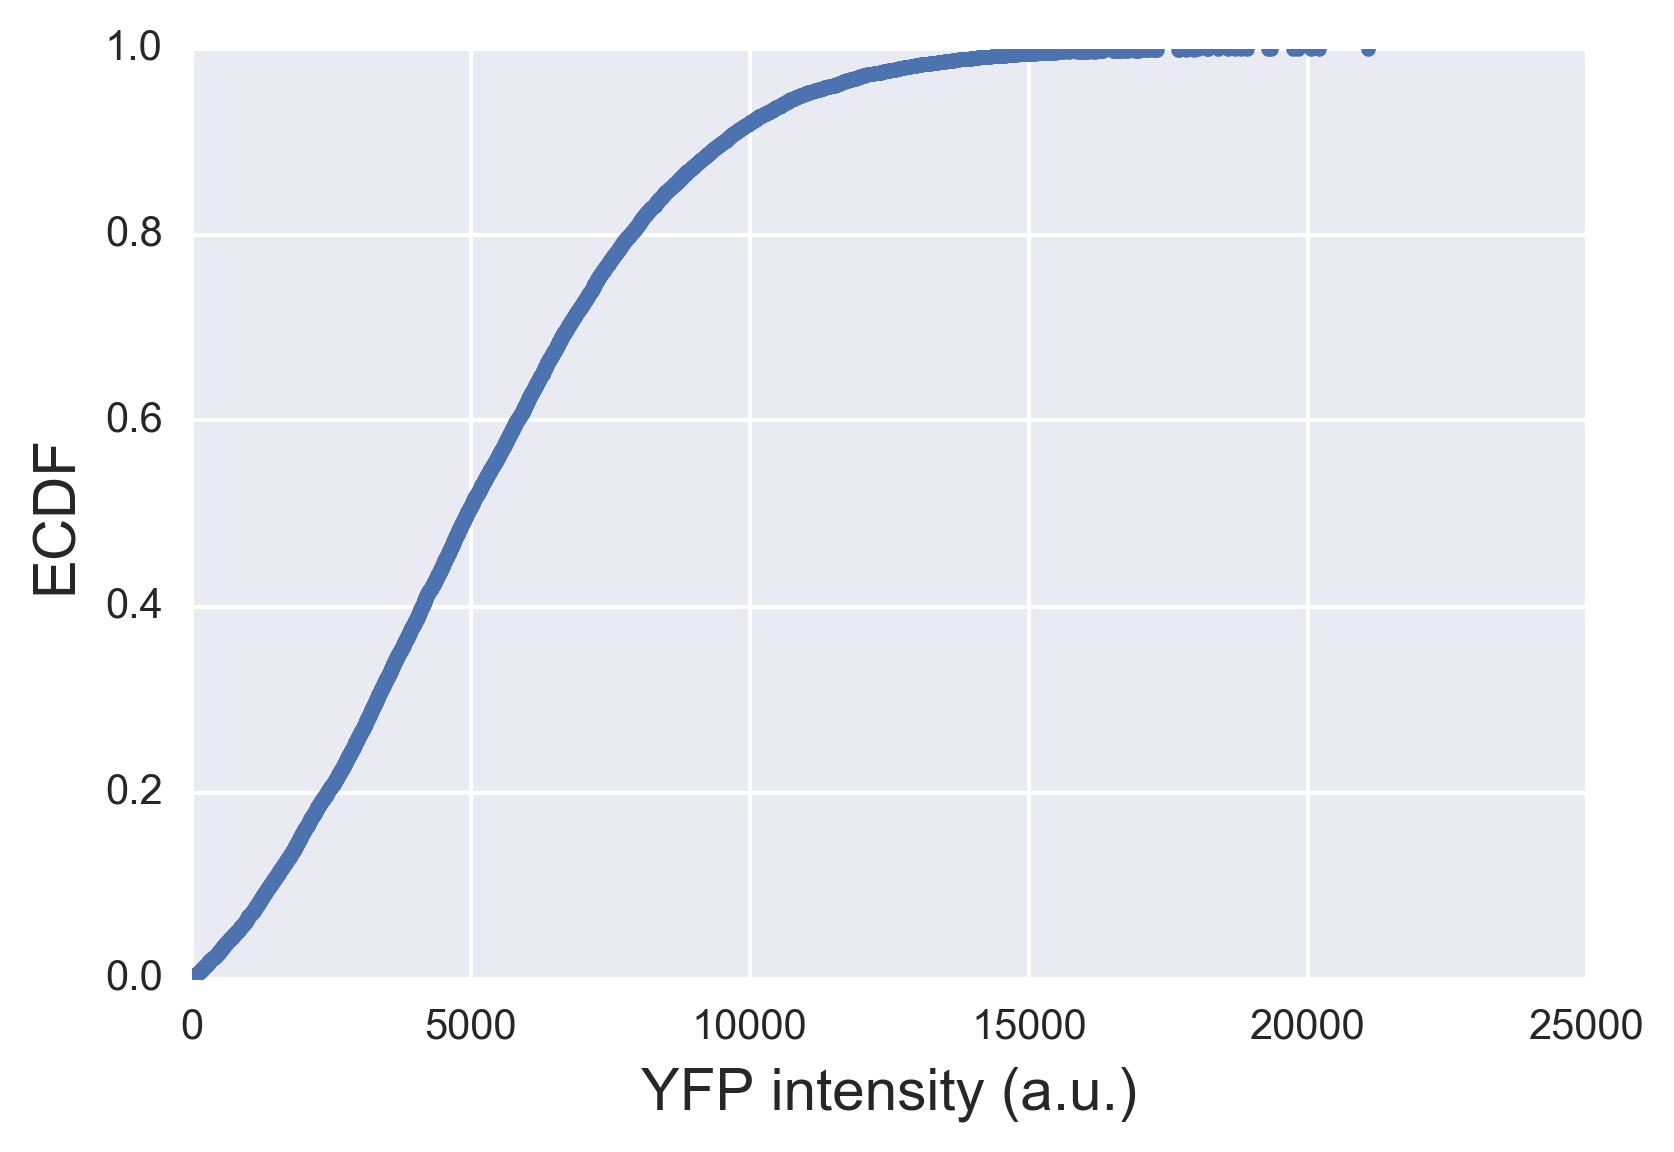

In [7]:
x, y = bebi103.ecdf(yfp[inds])
plt.plot(x, y, '.')
plt.xlabel('YFP intensity (a.u.)')
plt.ylabel('ECDF');

We can also compute the mean and its error bar.

In [8]:
np.mean(yfp[inds]), np.std(yfp[inds]) / np.sum(inds)

(5293.5117951426091, 0.21936990026703657)

Because we have so many samples, the error of the mean is tiny. For all practical purposes, it is negligible, and we will not consider it going forward.

Now that we have a means of doing the gating, we will perform gating for all files and add a column, `'gated'` with ones and zeros for which entries should be used. These are the files you downloaded.

In [9]:
# Get list of all file names
fnames = glob.glob('../data/flow_data/*.csv')

for f in fnames:
    # Load DataFrame
    df = pd.read_csv(f)

    # Extract useful indices
    inds = (df['FSC-A'] > 0) & (df['SSC-A'] > 0) & (df['FITC-A'] > 0)

    # Store a NumPy arrays for speed
    fsc, ssc, yfp = df.loc[inds,['FSC-A', 'SSC-A', 'FITC-A']].values.transpose()

    # Gate them
    gate_inds = gate_histogram(fsc, ssc, percentile=80, smooth_sigma=0.01)

    # Add gating information
    df.loc[inds, 'gate'] = gate_inds.astype(int)

    # Negative readings fail gating
    df.loc[~inds, 'gate'] = 0
    
    # Make sure the gate column is integer
    df['gate'] = df['gate'].astype(int)

    # Write out DataFrame
    df.to_csv(f, index=False)

#### Gating using kernel density estimation

We will now do gating using kernel density estimation. The idea here is that we get an estimate of the 2D probability distribution from which the forward and side scattering data were drawn using KDE. We then score each data points we measured and only keep the top $p$ percentile.

As we will see, this method is very slow, so we will not write general functions to do it. We will only go through the procedure once.

First, we need to set up some preliminaries necessary to feed into the scikit-learn KDE engine. Importantly, we need to center and scale the data. This means that we perform a linear transformation on the data such that the mean and variance of the forward and side scattering data is zero and one.

In [15]:
# Number of data points
n = len(fsc)

# Set bandwidth using Scott's method for 2D data
d = 2
bw = 1 / n**(1/(d+4))

# Generate array of x-y values to give to scikit-learn (use log scale)
scatter_data = np.log(np.vstack((fsc, ssc)).T)

# Center and rescale data
scatter_data_scaled = np.empty_like(scatter_data)
scatter_data_scaled[:,0] = sklearn.preprocessing.scale(scatter_data[:,0])
scatter_data_scaled[:,1] = sklearn.preprocessing.scale(scatter_data[:,1])

We can now generate our kernel density estimate. We will time it just to see how long this calculation takes.

In [16]:
# Perform KDE
kde = sklearn.neighbors.KernelDensity(bandwidth=bw)
%timeit kde.fit(scatter_data_scaled)

10 loops, best of 3: 77.3 ms per loop


That was not so bad at all, especially because we only have to do it once. Now, let's see how long it takes to evaluate the log of the PDF given by the KDE for a given data point.

In [22]:
data_point_to_score = np.array([scatter_data_scaled[0,:]])
%timeit kde.score_samples(data_point_to_score)

100 loops, best of 3: 1.91 ms per loop


This is about 2 ms per score. We have 100,000 samples to evaluate, which would take about 200 seconds, or about three minutes. Let's do it for this set, but given that we have 258 data sets, gating this way would take 14 hours.

In [29]:
# Perform gating
scores = kde.score_samples(scatter_data_scaled)

Now that we have the scores, we can pick out those in the top $p$ percentile. We will choose the top 20th percentile.

In [36]:
inds = scores > np.percentile(scores, 80)

Let's see how we did, generating the same plot as before.

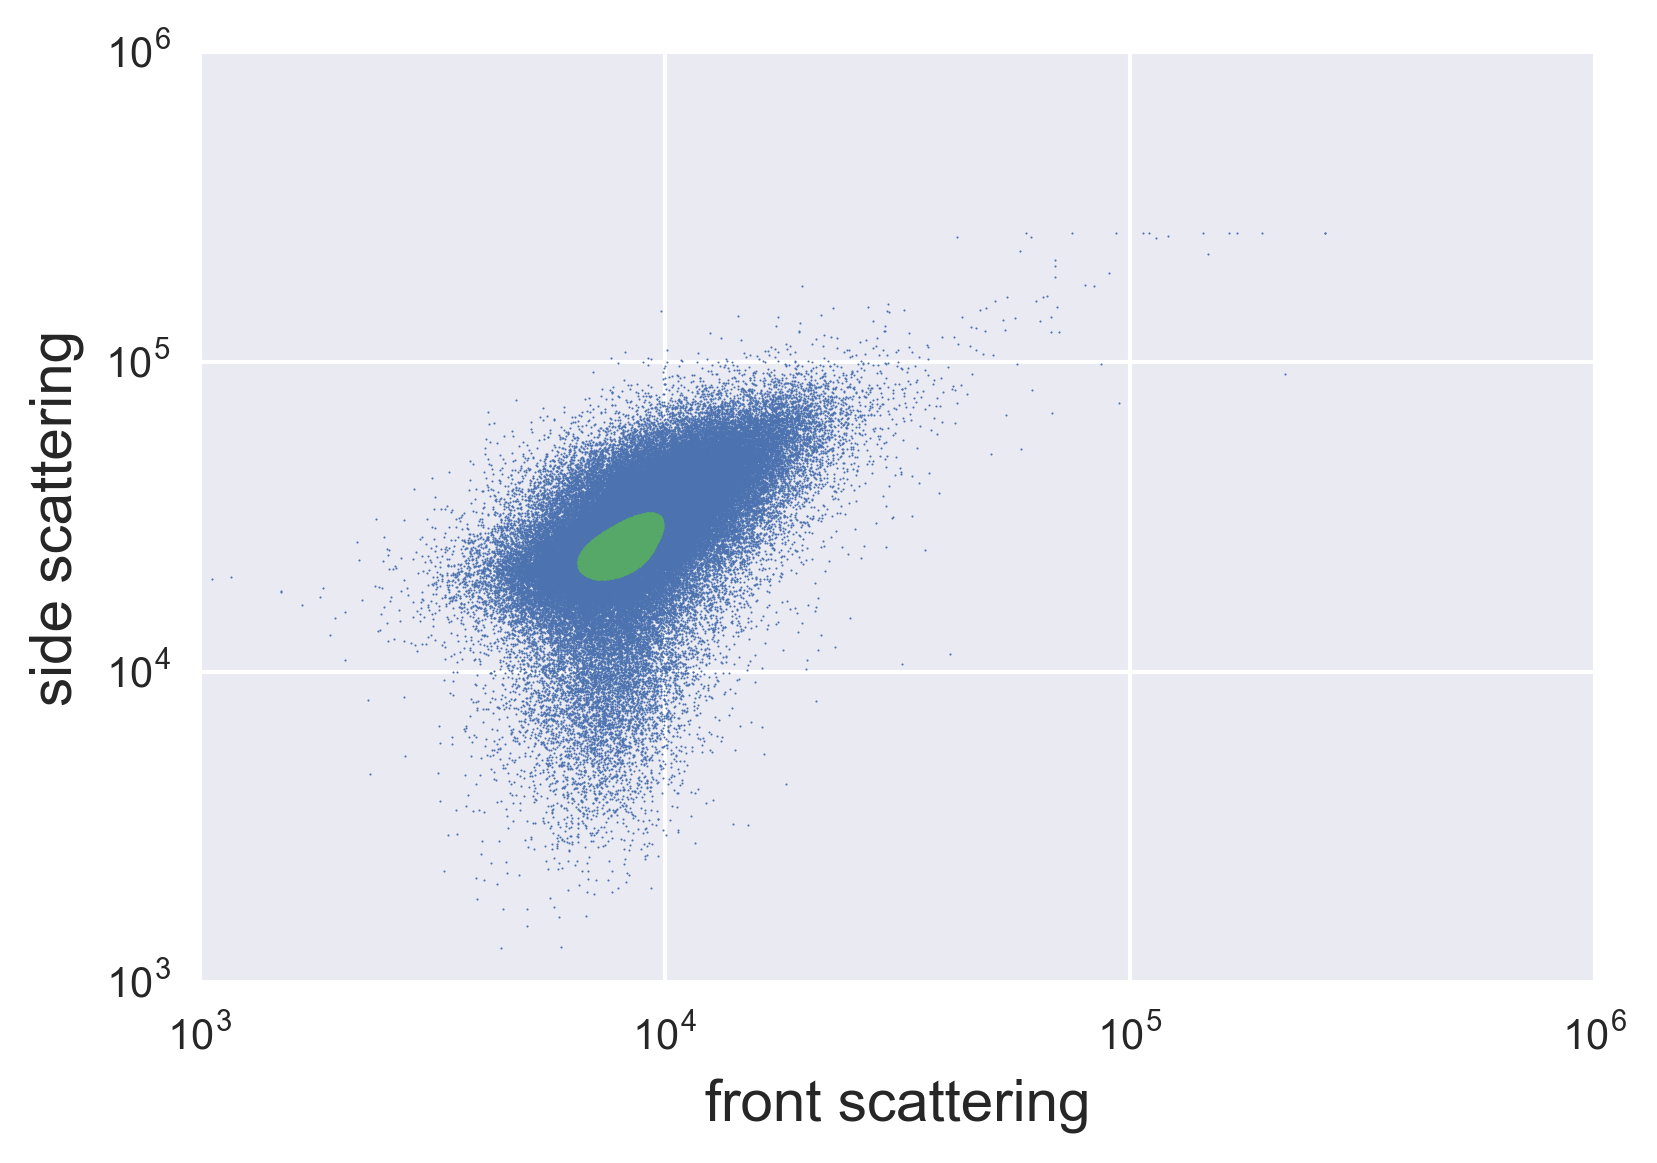

In [37]:
# Plot the excluded and included data
plt.loglog(fsc[~inds], ssc[~inds], '.', markersize=1, rasterized=True)
plt.loglog(fsc[inds], ssc[inds], '.', markersize=1, rasterized=True)
plt.xlabel('forward scattering')
plt.ylabel('side scattering');

We get a very similar result. So, the KDE method, and the histogram/contour method perform similarly (though it might be wise to do more tests). Given that the histogram/contour method is much much faster, we will stick with that one.

#### Performing the regression

Now that we have all the gating done, we can compute the mean fluorescence for all gated cells. First, we'll write a function to parse the file names to get the date, run number, strain, and IPTG concentration.

In [91]:
def parse_filename(fname):
    # Strip pre-directory and .csv suffix
    fname = os.path.split(fname)[-1][:-4]
    
    # Split at underscores to get fields
    fields = fname.split('_')
    
    # Return fields
    return int(fields[0]), int(fields[1]), fields[2], float(fields[3])

Now, we'll load in each data set and store the mean YFP intensity and other pertinent information in a nice, tidy, `DataFrame`.

In [38]:
# Set up DataFrame to store mean fluorescence
df_mean = pd.DataFrame(columns=['date', 'run', 'strain', 'iptg', 'yfp'],
                       index=np.arange(len(fnames)))

# Go through each file and compute and store mean fluorescence
for i, f in enumerate(fnames):
    fields = list(parse_filename(f))
    df = pd.read_csv(f)
    mean_yfp = np.mean(df.loc[df['gate']==1, 'FITC-A'])
    fields.append(mean_yfp)
    df_mean.loc[i,:] = fields
    
# Take a look
df_mean.head()

,date,run,strain,iptg,yfp
0,20160804,0,auto,0,4776.12
1,20160804,0,auto,0.1,4797.3
2,20160804,0,auto,1,4797.3
3,20160804,0,auto,10,4380.77
4,20160804,0,auto,100,4243.6


As per Manuel's lab notes, we should exclude the sample at 250 µM IPTG taken on August 4, 2016. We cannot be sure it was measured correctly.

In [112]:
inds = (df_mean['date'] == 20160804) & (df_mean['iptg'] == 250.0)
df_mean.loc[inds, 'yfp'] = np.nan
df_mean = df_mean.dropna()

Now, to compute the fold change, we need to make a new `DataFrame`. For each date/run/IPTG combination, the fold change is

\begin{align}
F = \frac{I_\text{RBS1027} - I_\text{auto}}{I_\text{delta} - I_\text{auto}},
\end{align}

where $I_i$ refers to the integrated fluorescence intensity of strain $i$. We can quickly compute this using a `GroupBy` object.

In [113]:
def fold_change(group):
    """
    Compute fold change from group containing RBS1027,
    auto, and delta fluorescence.
    """
    auto = group.loc[group['strain']=='auto', 'yfp'].values[0]
    rbs = group.loc[group['strain']=='RBS1027', 'yfp'].values[0]
    delta = group.loc[group['strain']=='delta', 'yfp'].values[0]
    return (rbs - auto) / (delta - auto)

# Make GroupBy
gb = df_mean.groupby(['date', 'run', 'iptg'])

# Make fold change DataFrame
df_fc = gb.apply(fold_change).reset_index()
df_fc = df_fc.rename(columns={0: 'fold_change'})

# Take a look
df_fc.head()

,date,run,iptg,fold_change
0,20160804,0,0.0,-0.015083
1,20160804,0,0.1,-0.000211
2,20160804,0,1.0,-0.000211
3,20160804,0,5.0,0.039131
4,20160804,0,10.0,0.086696


For convenience, we will add a column, 'trial' that corresponds to a unique date-run pair.

In [114]:
# Group by date/run pairs
my_gb = df_fc.groupby(['date', 'run'])

# Assign trial numbers
i = 0
for name, _ in my_gb:
    df_fc.loc[(df_fc['date']==name[0]) & (df_fc['run']==name[1]), 'trial'] = i
    i += 1

# Make sure trials are integers
df_fc['trial'] = df_fc['trial'].astype(int)

# Take a look
df_fc.head()

,date,run,iptg,fold_change,trial
0,20160804,0,0.0,-0.015083,0
1,20160804,0,0.1,-0.000211,0
2,20160804,0,1.0,-0.000211,0
3,20160804,0,5.0,0.039131,0
4,20160804,0,10.0,0.086696,0


Now we can plot the results.

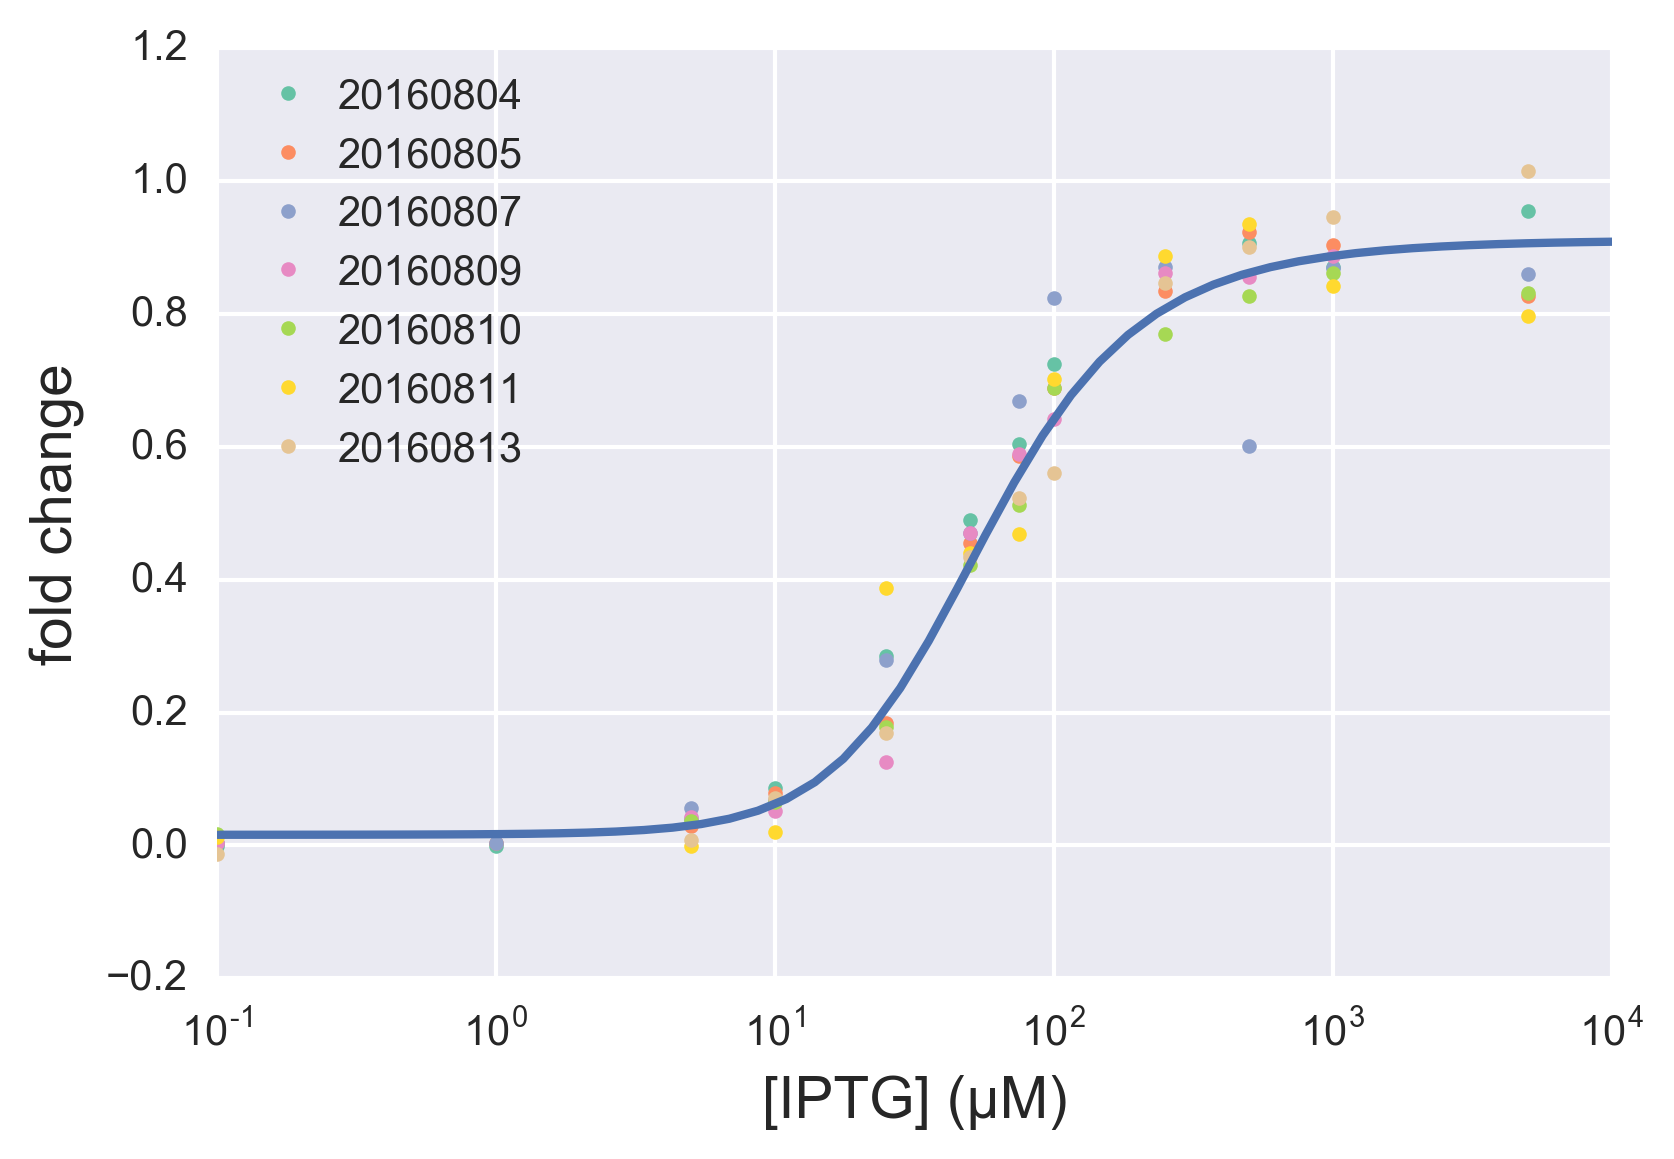

In [118]:
colors = ['#66c2a5','#fc8d62','#8da0cb','#e78ac3','#a6d854','#ffd92f','#e5c494']
i = 0
for _, group in df_fc.groupby(['date', 'run']):
    plt.semilogx(group['iptg'], group['fold_change'], '.', 
                 label=group.date.iloc[0], color=colors[i])
    i += 1

plt.legend(loc='upper left')
plt.xlabel('[IPTG] (µM)')
plt.ylabel('fold change')

Now, let's try the regression.

In [166]:
@numba.jit(nopython=True)
def theor_fold_change(c, RKD, KAI, KA, KI):
    """
    Theoretical fold change.
    """
    num = (1 + c/KA)**2
    denom = num + KAI * (1 + c/KI)**2
    return 1 / (1 + num / denom * RKD)


@numba.jit(nopython=True)
def log_likelihood(p, c, F):
    """
    Log likelihood, assuming Cauchy distributed about theoretical curve.
    """
    # Unpack parameters
    RKD, KAI, KA, KI, beta, sigma_RKD, sigma_KAI = p

    # Theoretical curve
    fc = theor_fold_change(c, RKD, KAI, KA, KI)
    
    return -len(c) * np.log(beta) \
            - np.sum(np.log(1.0 + ((F - fc) / beta)**2))

    
@numba.jit(nopython=True)
def log_prior(p, RKD_prior, KAI_prior, sigma_RKD_min, sigma_RKD_max,
             sigma_KAI_min, sigma_KAI_max):
    """
    Log prior.
    """
    if np.any(p[:5] <= 0):
        return -np.inf
    
    # Unpack parameters
    RKD, KAI, KA, KI, beta, sigma_RKD, sigma_KAI = p
    
    # Make sure sigmas are in range
    if not (sigma_RKD_min < sigma_RKD < sigma_RKD_max):
        return -np.inf
    if not (sigma_KAI_min < sigma_KAI < sigma_KAI_max):
        return -np.inf
    
    # Jeffreys priors on uninformative priors
    lp = -np.log(beta) - np.log(KA) - np.log(KI) \
                - np.log(sigma_RKD) - np.log(sigma_KAI)
        
    # Informative priors
    lp -= np.log(sigma_RKD) + (RKD - RKD_prior)**2 / 2 / sigma_RKD**2
    lp -= np.log(sigma_KAI) + (KAI - KAI_prior)**2 / 2 / sigma_KAI**2

    return lp


@numba.jit(nopython=True)
def log_posterior(p, c, F, RKD_prior, KAI_prior, sigma_RKD_min, sigma_RKD_max,
             sigma_KAI_min, sigma_KAI_max):
    """
    Log posterior.
    """
    lp = log_prior(p, RKD_prior, KAI_prior, sigma_RKD_min, sigma_RKD_max,
                   sigma_KAI_min, sigma_KAI_max)
    if lp == -np.inf:
        return -np.inf
    
    return lp + log_likelihood(p, c, F)

In [171]:
# Seed random number generator for reproducibility
np.random.seed(42)

# Define prior parameter values
RKD_prior = 2 * 130 / 4.2
KAI_prior = 0.01
sigma_RKD_min = RKD_prior * 0.001
sigma_RKD_max = RKD_prior * 1.2
sigma_KAI_min = KAI_prior * 0.001
sigma_KAI_max = KAI_prior * 1.2

# Set up parameters
p_dict = collections.OrderedDict(
        [('RKD', (np.random.uniform, (RKD_prior*0.9, RKD_prior*1.1))),
         ('KAI', (np.random.uniform, (KAI_prior*0.9, KAI_prior*1.1))),
         ('KA', (np.random.uniform, (100, 200))),
         ('KI', (np.random.uniform, (0.1, 1))),
         ('beta', (np.random.exponential, (1,))),
         ('sigma_RKD', (np.random.uniform, (sigma_RKD_min, sigma_RKD_max))),
         ('sigma_KAI', (np.random.uniform, (sigma_KAI_min, sigma_KAI_max)))])

# Run MCMC
args=(df_fc['iptg'].values, df_fc['fold_change'].values, RKD_prior, KAI_prior,
      sigma_RKD_min, sigma_RKD_max, sigma_KAI_min, sigma_KAI_max)
df_mcmc = bebi103.run_ensemble_emcee(
    log_posterior, p_dict=p_dict, args=args, n_walkers=50, 
    n_burn=500000, n_steps=50000)

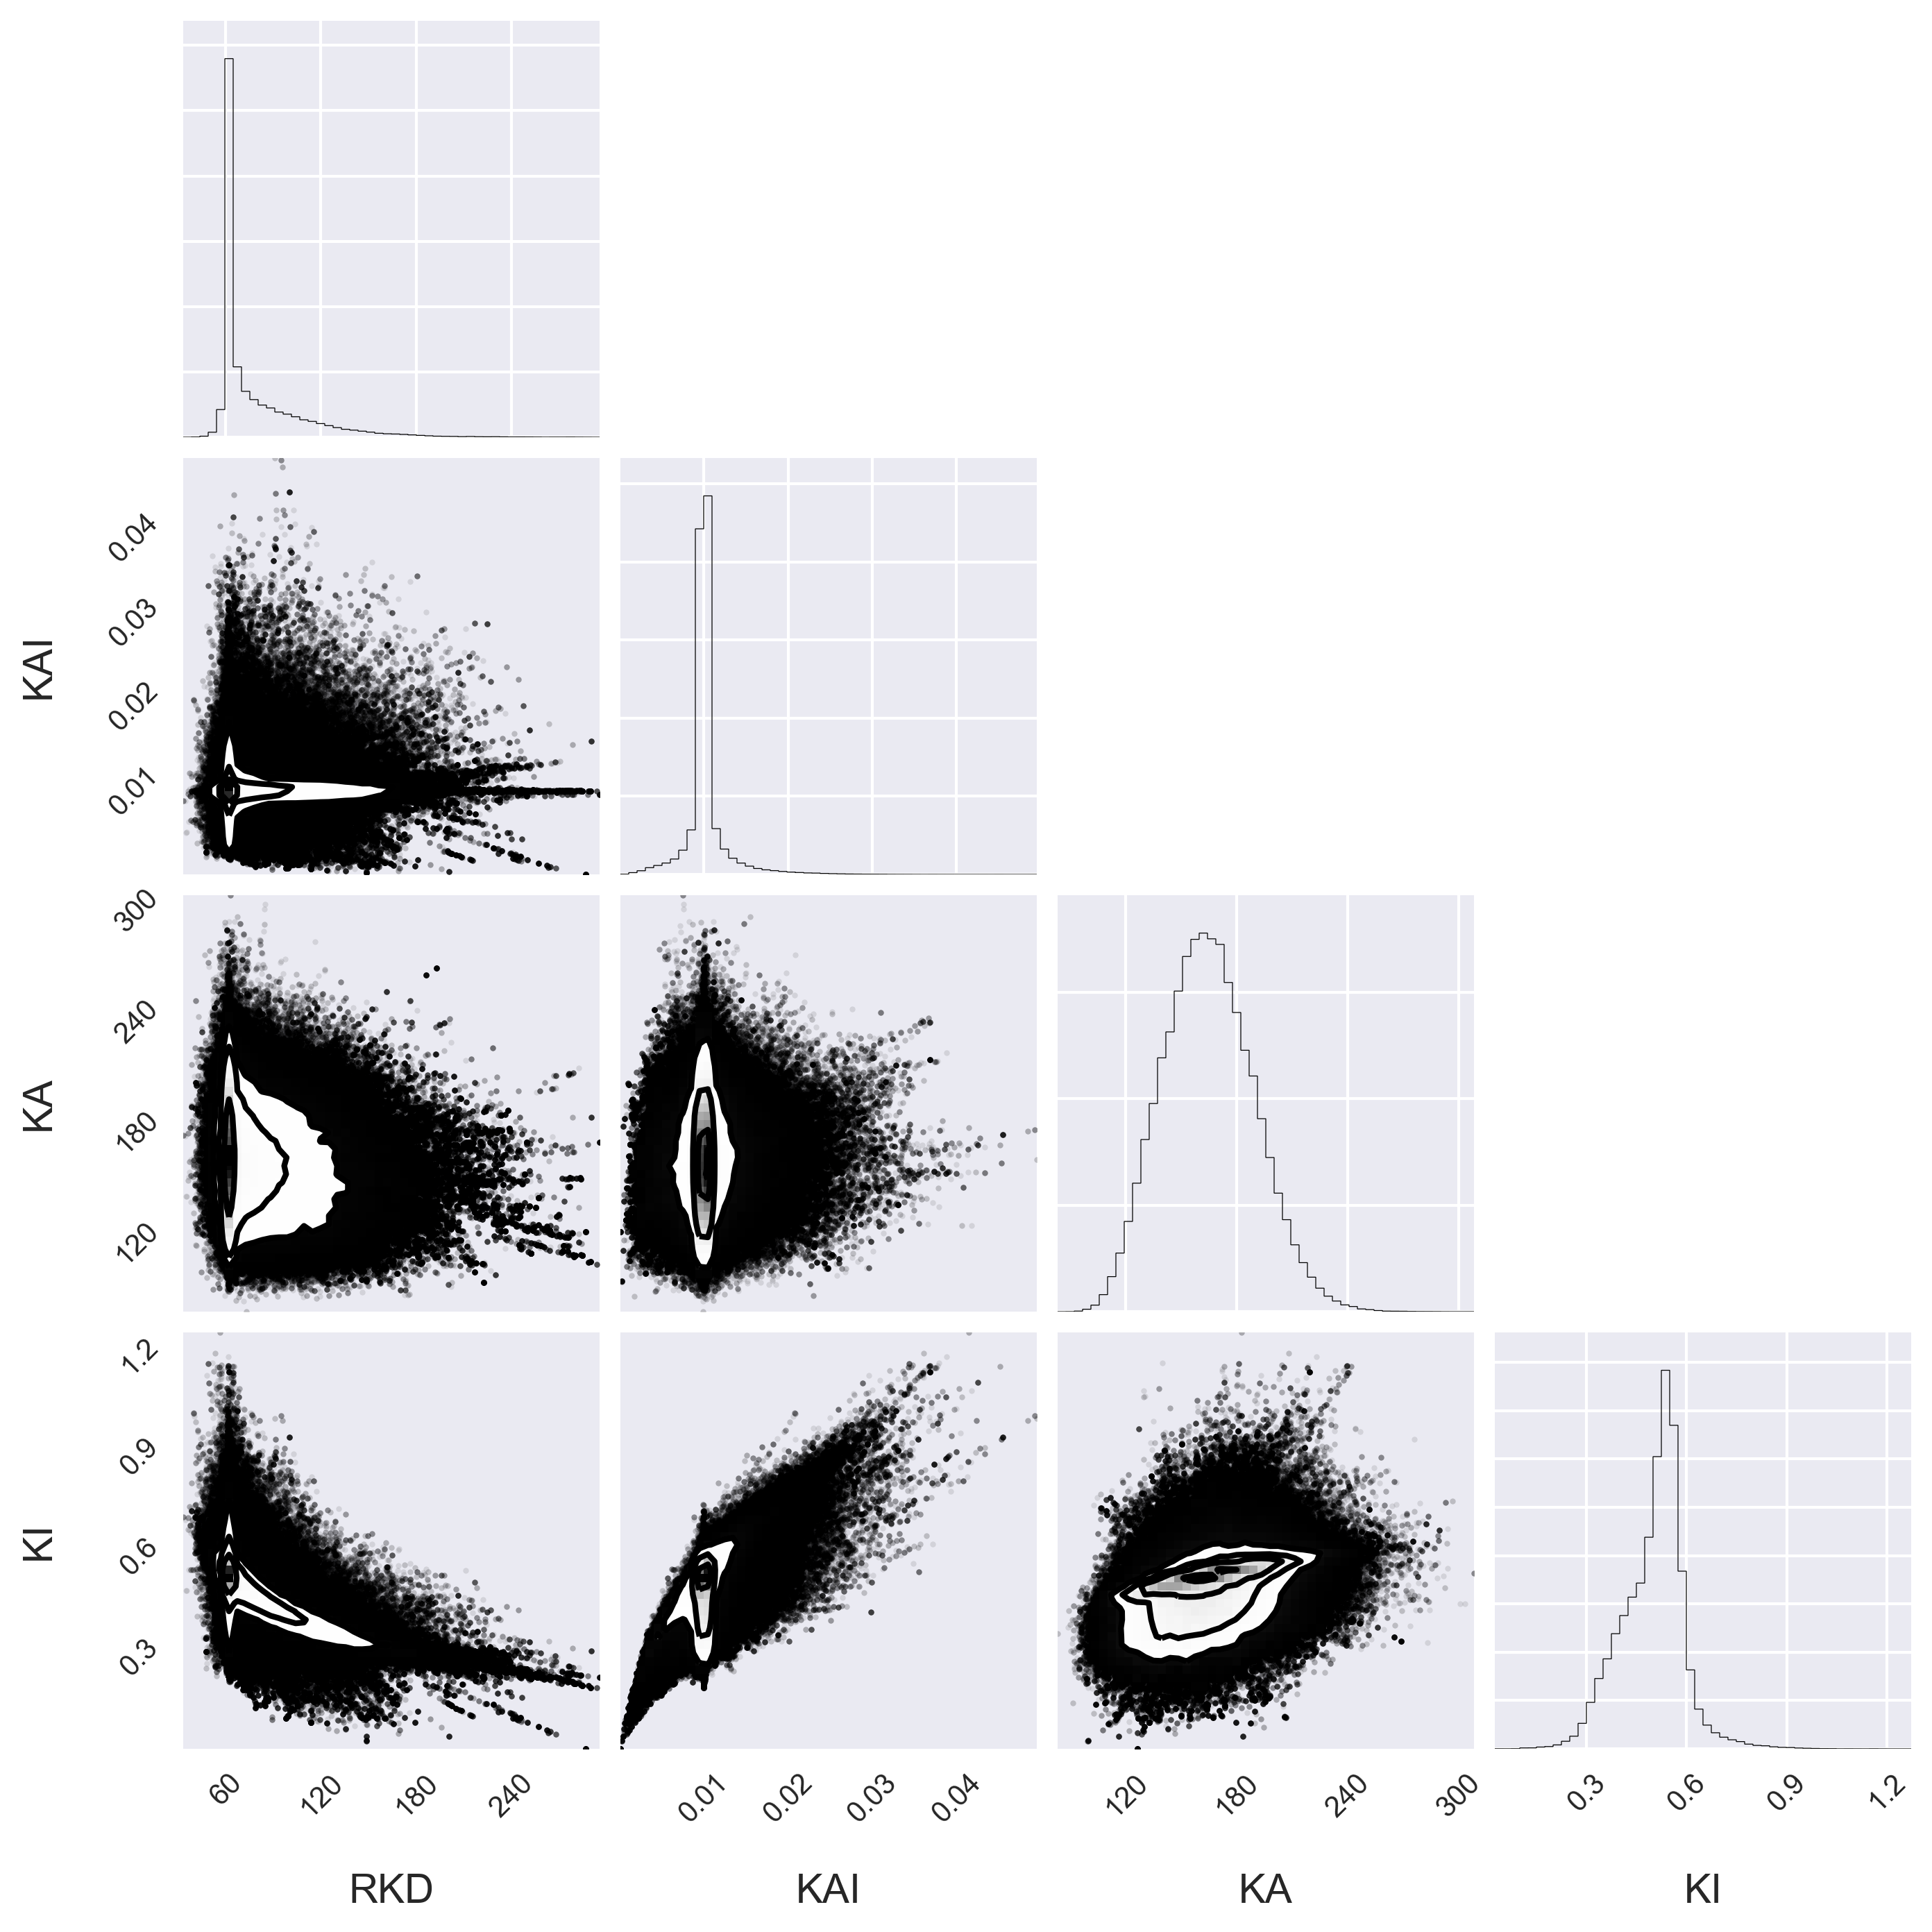

In [172]:
corner.corner(df_mcmc[['RKD', 'KAI', 'KA', 'KI']], 
              labels=['RKD', 'KAI', 'KA', 'KI'], bins=50);

Compute the modes and HPDs of the relevant parameters.

In [177]:
df_hpd = pd.DataFrame(columns=['RKD', 'KAI', 'KA', 'KI'],
                      index=['HPD_min', 'HPD_max', 'mode'])
most_prob_ind = np.argmax(df_mcmc['lnprob'])
for param in df_hpd.columns:
    hpd_min, hpd_max = bebi103.hpd(df_mcmc[param], 0.95)
    mode = df_mcmc.loc[most_prob_ind, param]
    df_hpd.loc[['HPD_min', 'HPD_max', 'mode'], param] = [hpd_min, hpd_max, mode]

df_hpd

,RKD,KAI,KA,KI
HPD_min,52.892,0.00447196,117.581,0.285225
HPD_max,143.738,0.0153441,212.461,0.651733
mode,61.9281,0.0100003,164.908,0.547084


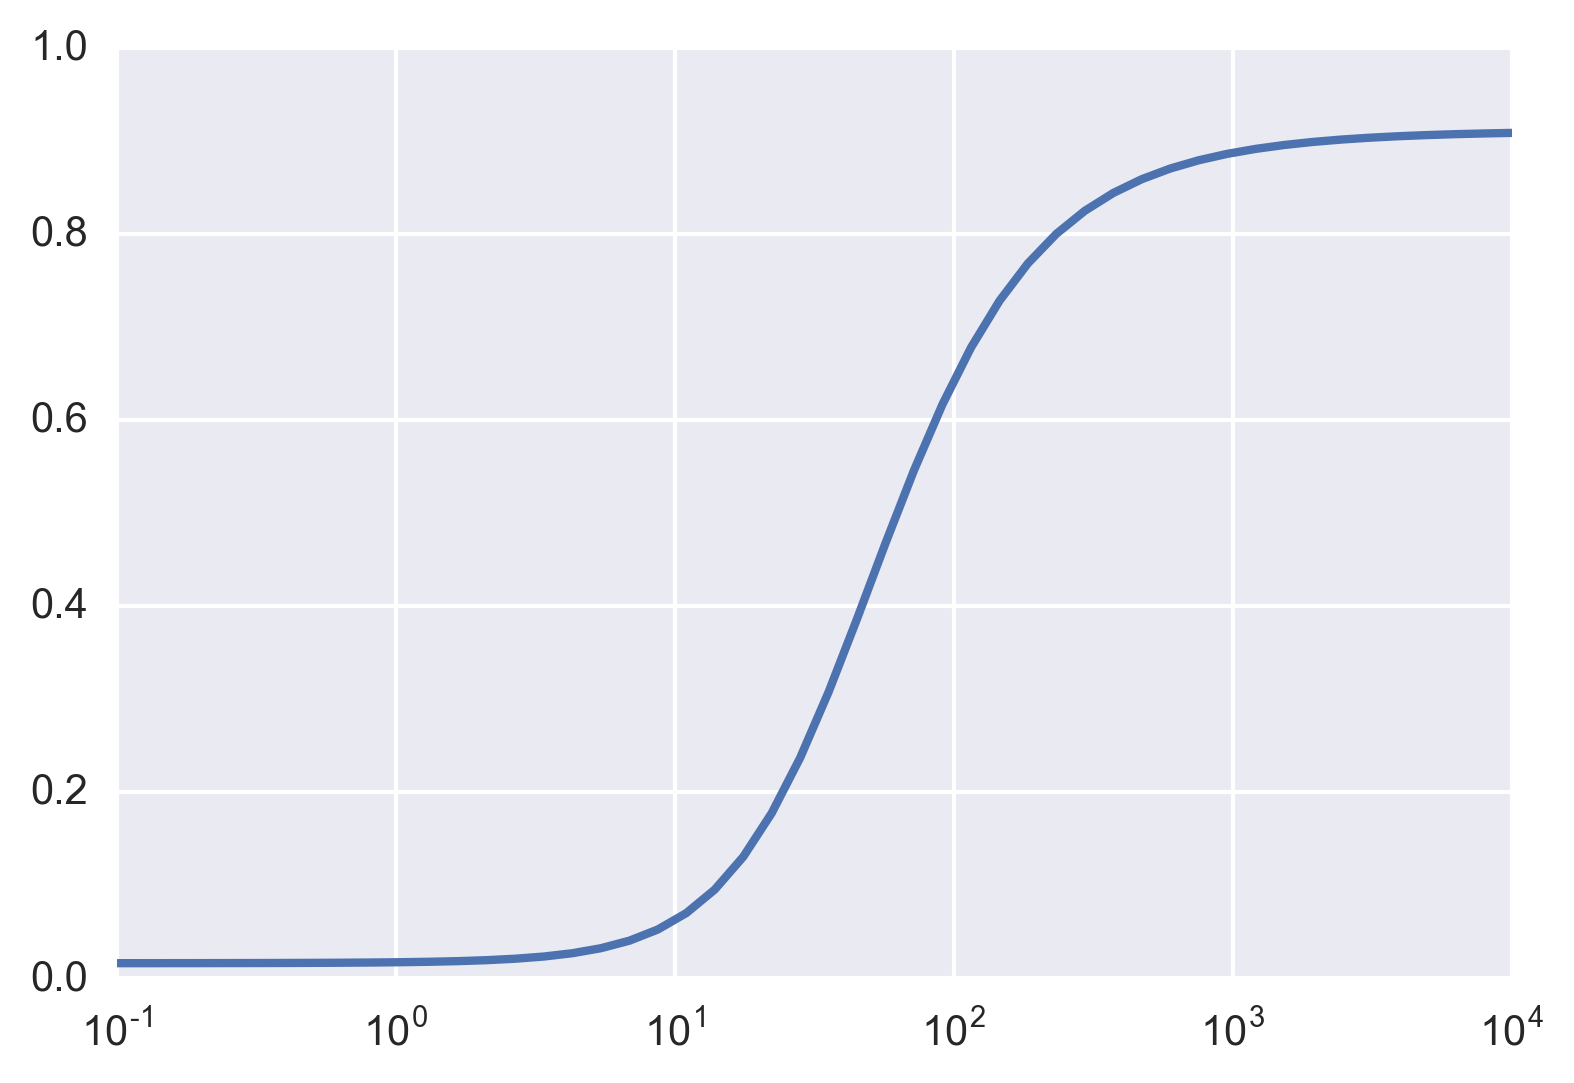

In [117]:
c = np.logspace(-1, 4)
KI = 0.56
KA = 141
KAI = 0.01
RKD = 2 * 130 / 4.2
fc = theor_fold_change(c, RKD, KAI, KA, KI)
plt.semilogx(c, fc)